In [23]:
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [42]:
import numpy as np

def rotate_point(point, orientation):
    roll, pitch, yaw = np.radians(orientation)  # Convert to radians

    # Rotation matrices
    R_x = np.array([[1, 0, 0],
                    [0, np.cos(roll), -np.sin(roll)],
                    [0, np.sin(roll), np.cos(roll)]])
    
    R_y = np.array([[np.cos(pitch), 0, np.sin(pitch)],
                    [0, 1, 0],
                    [-np.sin(pitch), 0, np.cos(pitch)]])
    
    R_z = np.array([[np.cos(yaw), -np.sin(yaw), 0],
                    [np.sin(yaw), np.cos(yaw), 0],
                    [0, 0, 1]])

    R = R_x @ R_y @ R_z
    return R @ point

def create_general_polygon(n_sides, side_length, origin_coords, orientation=(0, 0, 0)):
    angles = [2 * np.pi * i / n_sides for i in range(n_sides)]
    coordinates = []
    
    for angle in angles:
        x = side_length * np.cos(angle)
        y = side_length * np.sin(angle)
        z = 0
        
        rotated_point = rotate_point(np.array([x, y, z]), orientation)
        x, y, z = rotated_point + origin_coords

        coordinates.append((x, y, z))
        
    return coordinates

def create_sphere(radius, center_coords):
    coordinates = []
    
    for i in range(360):
        for j in range(180):
            theta = math.radians(i)
            phi = math.radians(j)
            x = center_coords[0] + radius * math.sin(phi) * math.cos(theta)
            y = center_coords[1] + radius * math.sin(phi) * math.sin(theta)
            z = center_coords[2] + radius * math.cos(phi)
            coordinates.append((x, y, z))
            
    return coordinates

def create_cuboid(width, height, depth, origin_coords, orientation=(0, 0, 0)):
    half_width = width / 2
    half_height = height / 2
    half_depth = depth / 2
    
    dx, dy, dz = origin_coords

    vertices = [
        (dx - half_width, dy - half_height, dz - half_depth),
        (dx + half_width, dy - half_height, dz - half_depth),
        (dx + half_width, dy + half_height, dz - half_depth),
        (dx - half_width, dy + half_height, dz - half_depth),
        (dx - half_width, dy - half_height, dz + half_depth),
        (dx + half_width, dy - half_height, dz + half_depth),
        (dx + half_width, dy + half_height, dz + half_depth),
        (dx - half_width, dy + half_height, dz + half_depth)
    ]

    rotated_vertices = [rotate_point(vertex, orientation) for vertex in vertices]

    return rotated_vertices

def generate_shape_coordinates(shape, params, center_coords, orientation):
    if shape == 'polygon':
        return create_general_polygon(params['n_sides'], params['side_length'], center_coords, orientation)
    elif shape == 'sphere':
        return create_sphere(params['radius'], center_coords)
    elif shape == 'cuboid':
        return create_cuboid(params['width'], params['height'], params['depth'], center_coords)
    else:
        raise ValueError("Invalid shape specified")

# # Example usage:
# shape = 'polygon'
# params = {'n_sides': 5, 'side_length': 1}
# center_coords = (0, 0, 0)
# orientation = (0, 0, 45)

# polygon_coords = generate_shape_coordinates(shape, params, center_coords, orientation)
# print(polygon_coords)

# Example usage:
n_sides = 5
side_length = 1
origin_coords = (0, 0, 0)
orientation = (0, 0, 45)

polygon_vertices = create_general_polygon(n_sides, side_length, origin_coords, orientation)
print(polygon_vertices)

[(0.7071067811865476, 0.7071067811865475, 0.0), (-0.4539904997395467, 0.8910065241883679, 0.0), (-0.9876883405951378, -0.15643446504023062, 0.0), (-0.15643446504023106, -0.9876883405951377, 0.0), (0.8910065241883677, -0.45399049973954697, 0.0)]


In [43]:
# Example usage:
width = 1
height = 2
depth = 3
origin_coords = (0, 0, 0)

cuboid_coords = create_cuboid(width, height, depth, origin_coords)
print(cuboid_coords)

[array([-0.5, -1. , -1.5]), array([ 0.5, -1. , -1.5]), array([ 0.5,  1. , -1.5]), array([-0.5,  1. , -1.5]), array([-0.5, -1. ,  1.5]), array([ 0.5, -1. ,  1.5]), array([0.5, 1. , 1.5]), array([-0.5,  1. ,  1.5])]


In [44]:
def ucl_format_coordinates(shape, params, center_coords, material_type, component_group, comment, reflectivity, specularity):
    coordinates = generate_shape_coordinates(shape, params, center_coords, orientation)
    
    n_points = len(coordinates)
    header_line = f"{n_points} // {material_type:03d} {component_group:04d} {comment}"
    
    coordinate_lines = "\n".join(" ".join(f"{coord:.3f}" for coord in point) for point in coordinates)
    final_line = f"{reflectivity:.1f} {specularity:.1f}"
    
    return f"{header_line}\n{n_points}\n{coordinate_lines}\n{final_line}"

# Example usage:
shape = 'polygon'
params = {'n_sides': 5, 'side_length': 1}
center_coords = (0, 0, 0)
orientation = (0, 0, 45)
material_type = 1
component_group = 1
comment = "pentagon covered in MLI"
reflectivity = 0.1
specularity = 0.5

formatted_coords = ucl_format_coordinates(shape, params, center_coords, material_type, component_group, comment, reflectivity, specularity)
print(formatted_coords)


5 // 001 0001 pentagon covered in MLI
5
0.707 0.707 0.000
-0.454 0.891 0.000
-0.988 -0.156 0.000
-0.156 -0.988 0.000
0.891 -0.454 0.000
0.1 0.5


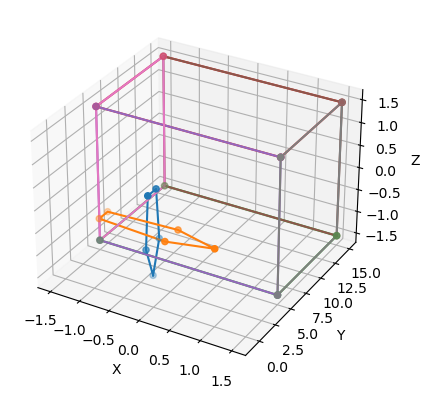

In [62]:
def plot_shapes(shapes_data):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    for shape_data in shapes_data:
        shape, params, center_coords, orientation = shape_data
        coordinates = generate_shape_coordinates(shape, params, center_coords, orientation)

        if shape == 'cuboid':
            vertices = coordinates
            # Define the indices of the vertices that form each face
            face_indices = [
                (0, 1, 2, 3),
                (4, 5, 6, 7),
                (0, 1, 5, 4),
                (2, 3, 7, 6),
                (0, 3, 7, 4),
                (1, 2, 6, 5)
            ]
            
            for face in face_indices:
                face_coords = [vertices[i] for i in face]
                xs, ys, zs = zip(*face_coords)
                ax.scatter(xs, ys, zs)
                xs, ys, zs = zip(*face_coords, face_coords[0])  # Add the first coordinate again to close the polygon
                ax.plot(xs, ys, zs, linestyle='-')
        else:
            xs, ys, zs = zip(*coordinates)
            ax.scatter(xs, ys, zs)
            xs, ys, zs = zip(*coordinates, coordinates[0])  # Add the first coordinate again to close the polygon
            ax.plot(xs, ys, zs, linestyle='-')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()

# Example usage:
shapes_data = [
    ('polygon', {'n_sides': 5, 'side_length': 1}, (0, 0, 0), (0, 90, 0)),
    ('polygon', {'n_sides': 5, 'side_length': 1}, (0, 0, 0), (0, 0, 0)),
    ('cuboid', {'width': 3, 'height': 10, 'depth': 3}, (0, 10, 0), (0, 0, 0)),
]

plot_shapes(shapes_data)


In [ ]:
# Can you also write me functions for cylinders, planar rings and paraboloids as well as truncated paraboloids, cones and truncated cones